# CASTEP Al Slab benchmark performance

This notebook compares the performance of the small Al Slab (al3x3) benchmark across different HPC facilities. The general comparison is followed by more detailed analysis comparing performance of different numerical libraries on the ARCHER2 system.

We compute the mean time per SCF cycle from all cycles in the output file apart from the fastest and slowest cycle times. Performance is plotted as SCF cycles per second.

## Setup section

Import the required modules and define useful functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (12,6)
import seaborn as sns
sns.set(font_scale=1.5, context="paper", style="white", font="serif")
pal = sns.color_palette()
cols = pal.as_hex()

In [2]:
import sys
sys.path.append('../../../python-modules')

In [3]:
from utilities import filemanip, sysinfo
from appanalysis import castep

In [4]:
sysdetails = sysinfo.getdetails('../../../systems.yaml')

../../../python-modules/utilities/sysinfo.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  systems = yaml.load(input)


## Process data

In [7]:
systems = ['ARCHER','ARCHER2','Athena','Cirrus','Thomas','Tesseract','CSD3-Skylake','EPCC-CascadeLake']
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}
castep_df = {}

for system in systems:
    wdir = '../al3x3/results/' + system
    filelist = filemanip.get_filelist(wdir, 'al3x3_')
    sysdict = sysdetails[system]
    names[system] = sysdict['Name']
    cpn[system] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(sysdict['Name'])
    castep_df[system] = pd.DataFrame(castep.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes[system], perf_nodes[system] = castep.get_perf_stats(castep_df[system], 'max', writestats=True, plot_cores=False)
    cores[system], perf_cores[system] = castep.get_perf_stats(castep_df[system], 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER
                             Perf                                  Tcalc  \
                              min    median       max      mean      min   
Nodes Processes Threads                                                    
1     24        1        0.005409  0.005429  0.005519  0.005453  2365.33   
2     48        1        0.011341  0.011341  0.011341  0.011341      NaN   
4     96        1        0.019480  0.019480  0.019480  0.019480   771.63   
8     192       1        0.030145  0.030145  0.030145  0.030145   567.87   
16    384       1        0.034719  0.034719  0.034719  0.034719   447.44   

                                                    Count  
                          median      max      mean   sum  
Nodes Processes Threads                                    
1     24        1        2388.68  2516.43  2410.598     5  
2     48        1            NaN      NaN       NaN     1  
4     96        1         771.63   771.63   771.630     1  
8     192       1      

                             Perf                                  Tcalc  \
                              min    median       max      mean      min   
Nodes Processes Threads                                                    
1     24        1        0.008109  0.009431  0.009459  0.009216  1246.78   
2     48        1        0.018912  0.018912  0.018912  0.018912   624.90   
4     96        1        0.033382  0.033382  0.033382  0.033382   355.58   
8     192       1        0.053430  0.053430  0.053430  0.053430   222.71   
16    384       1        0.057745  0.057745  0.057745  0.057745   202.24   

                                                        Count  
                           median      max         mean   sum  
Nodes Processes Threads                                        
1     24        1        1274.155  1447.95  1303.888333     6  
2     48        1         624.900   624.90   624.900000     1  
4     96        1         355.580   355.58   355.580000     1  
8     1

## Performance Comparison

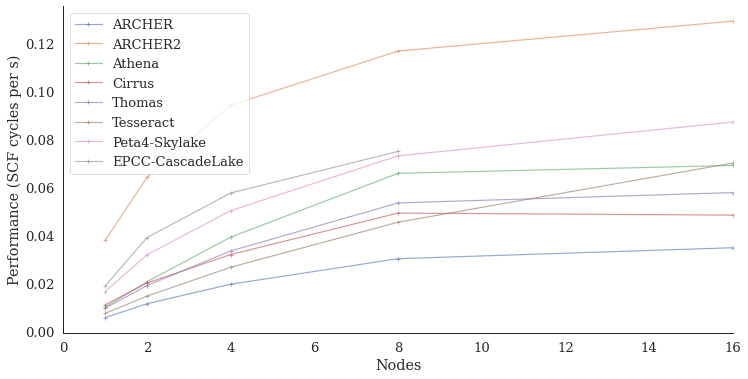

In [8]:
for system in systems:
    plt.plot(nodes[system], perf_nodes[system], '-+', label=names[system], alpha=0.6)
plt.xlim((0,16))
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

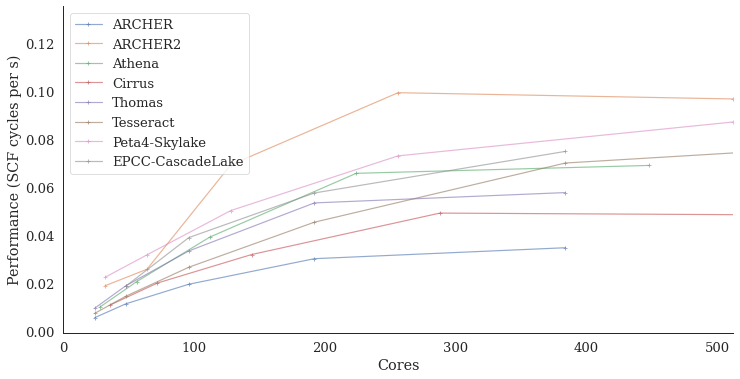

In [9]:
for system in systems:
    plt.plot(cores[system], perf_cores[system], '-+', label=names[system], alpha=0.6)
plt.xlim((0,512))
plt.xlabel('Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

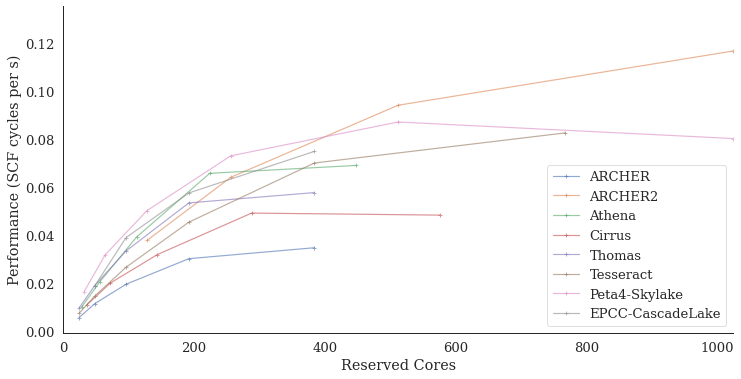

In [10]:
perf_totcores = {}
for system in systems:
    totcores = [n * cpn[system] for n in nodes[system]]
    plt.plot(totcores, perf_nodes[system], '-+', label=names[system], alpha=0.6)
plt.xlim((0,1024))
plt.xlabel('Reserved Cores')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

## ARCHER2: Performance of binding options and shared memory segments

This section looks at the ARCHER2 performance with respect to two different Slurm binding options: `cores` and `rank` and the choice of different values for the CASTEP `num_proc_in_smp` option which uses shared memory segments. The tables have the following columns:

 - Nodes: number of nodes
 - Perf.: the performance of CASTEP in SCF cycles/s
 - Perfect: perfect speedup relative to single node performance
 - Speedup: measured speedup relative to single node performance
 - Eff.: parallel efficiency

Binding = cores, nSMP = 1
     Nodes     Perf.   Perfect   Speedup      Eff.
         1   0.03776      1.00      1.00    100.00
         2   0.05780      2.00      1.53     76.53
         4   0.04469      4.00      1.18     29.58
         8   0.02373      8.00      0.63      7.86
        16   0.01919     16.00      0.51      3.18
Binding = cores, nSMP = 2
     Nodes     Perf.   Perfect   Speedup      Eff.
         1   0.03108      1.00      1.00    100.00
         2   0.04657      2.00      1.50     74.91
         4   0.06483      4.00      2.09     52.14
         8   0.05379      8.00      1.73     21.63
        16   0.04948     16.00      1.59      9.95
Binding = cores, nSMP = 4
     Nodes     Perf.   Perfect   Speedup      Eff.
         1   0.01981      1.00      1.00    100.00
         2   0.03734      2.00      1.88     94.24
         4   0.05547      4.00      2.80     69.99
         8   0.07534      8.00      3.80     47.53
        16   0.07570     16.00      3.82     23.88
Bind

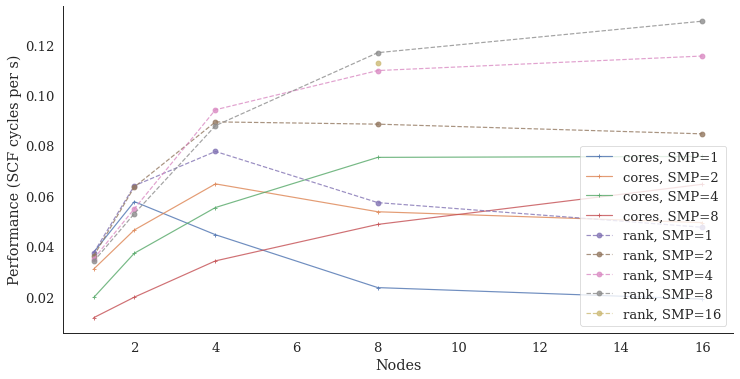

In [11]:
pins = ['cores','rank']
style = {}
style['cores'] = '-+'
style['rank'] = '--o'
for pin in pins:
    df = castep_df['ARCHER2'].query(f'(Pinning == "{pin}")')
    smps = df.nSMP.unique()
    for smp in smps:
        df_temp = df.query(f'(nSMP == {smp})')
        df_temp = df_temp.drop(['File', 'Date','Pinning'], 1)
        groupf = {'Perf':['min','median','max','mean'], 'Tcalc':['min','median','max','mean'], 'Count':'sum'}
        df_group = df_group = df_temp.sort_values(by='Nodes').groupby(['Nodes']).agg(groupf)
        perf = df_group['Perf','max'].tolist()
        count = df_group.index.get_level_values(0).tolist()
        plt.plot(count, perf, style[pin], label=f'{pin}, SMP={smp}', alpha=0.8)
        print(f'Binding = {pin}, nSMP = {smp}')
        print(f'{"Nodes":>10s}{"Perf.":>10s}{"Perfect":>10s}{"Speedup":>10s}{"Eff.":>10s}')
        for i, p in enumerate(perf):
            speedup = p / perf[0]
            perfect = count[i]/count[0]
            eff = 100 * speedup/perfect
            print(f'{count[i]:>10d}{p:>10.5f}{perfect:>10.2f}{speedup:>10.2f}{eff:>10.2f}')
        
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='lower right')
sns.despine()

## ARCHER2: Comparison of different numerical libraries

In [19]:
results = ['ARCHER2','ARCHER2_MKL195','ARCHER2_MKL212','ARCHER2_AOCL3']
systems = {'ARCHER2': 'ARCHER2', 'ARCHER2_MKL195': 'ARCHER2', 'ARCHER2_MKL212': 'ARCHER2', 'ARCHER2_AOCL3': 'ARCHER2'}
perf = {}
notes = {}
names = {}
nodes = {}
cores = {}
perf_nodes = {}
perf_cores = {}
cpn = {}

for res in results:
    wdir = '../al3x3/results/' + res
    filelist = filemanip.get_filelist(wdir, 'al3x3_')
    sysdict = sysdetails[systems[res]]
    names[res] = res
    cpn[res] = sysdict['PCores']*sysdict['PPerNode']
    print('\n============================================================')
    print(res)
    castep_df[res] = pd.DataFrame(castep.create_df_list(filelist, sysdict['PCores']*sysdict['PPerNode']))
    nodes[res], perf_nodes[res] = castep.get_perf_stats(castep_df[res], 'max', writestats=True, plot_cores=False)
    cores[res], perf_cores[res] = castep.get_perf_stats(castep_df[res], 'max', writestats=False, plot_cores=True)
    print('\n============================================================')


ARCHER2
                             Perf                                 Tcalc  \
                              min    median       max      mean     min   
Nodes Processes Threads                                                   
1     32        1        0.018863  0.018863  0.018863  0.018863  636.39   
      64        1        0.025695  0.025717  0.025740  0.025717  468.05   
      128       1        0.011632  0.035684  0.037764  0.030602  324.15   
2     128       1        0.046240  0.046240  0.046240  0.046240  265.80   
      256       1        0.019930  0.053029  0.064087  0.046586  194.82   
4     128       1        0.062170  0.065729  0.069288  0.065729  178.00   
      256       1        0.069007  0.070485  0.078201  0.072564  156.36   
                2        0.067448  0.067448  0.067448  0.067448  184.40   
      512       1        0.032072  0.055467  0.094206  0.061148  132.14   
8     256       1        0.094776  0.097108  0.099441  0.097108  125.01   
      512       

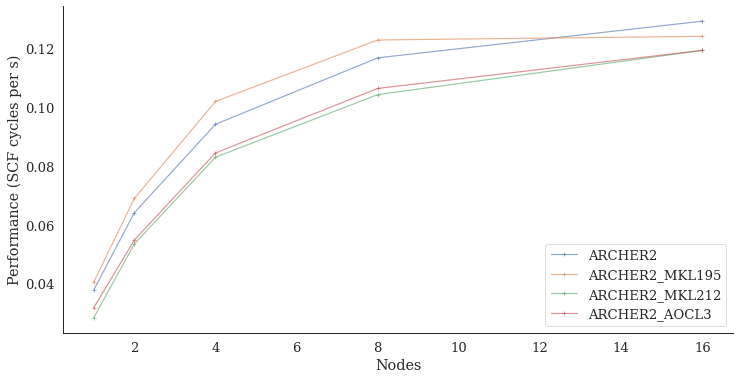

In [20]:
for res in results:
    plt.plot(nodes[res], perf_nodes[res], '-+', label=names[res], alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('Performance (SCF cycles per s)')
plt.legend(loc='best')
sns.despine()

In [32]:
print(f"{'Nodes':>10s}", end='')
for res in results:
    print(f"{res:>15s}", end='')
print()
for i in range(len(nodes['ARCHER2'])):
    print(f"{nodes['ARCHER2'][i]:>10d}", end='')
    for res in results:
        print(f"{perf_nodes[res][i]:>15.5f}", end='')
    print()


     Nodes        ARCHER2 ARCHER2_MKL195 ARCHER2_MKL212  ARCHER2_AOCL3
         1        0.03776        0.04050        0.02838        0.03177
         2        0.06409        0.06895        0.05346        0.05477
         4        0.09421        0.10196        0.08300        0.08445
         8        0.11682        0.12291        0.10432        0.10641
        16        0.12930        0.12415        0.11937        0.11937
